# Visualiser

In this notebook we'll explore how to finally visualise the result of an entire workflow (examples `[1-5]`) into a maps—static and interactive visualisers.

Let’s make an enriched layer pop!

**Data source used**:
- PLUTO data from NYC Open Data. https://www.nyc.gov/content/planning/pages/resources/datasets/mappluto-pluto-change

Let’s make some pretty maps! 🗺️


In [1]:
import urban_mapper as um

# Kick off UrbanMapper
mapper = um.UrbanMapper()

## Preparing the Data and Layer

First, let’s load data, create a layer, and enrich it with average building floors.

Note that:

- Loader example can be seen in `examples/Basics/loader.ipynb`
- Urban Layer example can be seen in `examples/Basics/urban_layer.ipynb`
- Enricher example can be see in `examples/Basics/enricher.ipynb`
- Imputer example can be seen in `examples/Basics/imputer.ipynb`
- Filter example can be seen in `examples/Basics/filter.ipynb`

In [16]:
######
#
# We will on purpose do inline chaining of the methods to fasten the process.
#
######

# Load data
# Note: For the documentation interactive mode, we only query 5000 records from the dataset.  Feel free to remove for a more realistic analysis.
data = mapper.loader.from_huggingface("oscur/pluto", number_of_rows=5000, streaming=True).with_columns("longitude", "latitude").load()

# Create urban layer
layer = mapper.urban_layer.with_type("streets_intersections").from_place("Downtown Brooklyn, New York City, USA").build()

# Impute your data if they contain missing values
data = mapper.imputer.with_type("SimpleGeoImputer").on_columns("longitude", "latitude").transform(data, layer)

# Filter your data if they contain data beyond the bounding box your urban layer above
data = mapper.filter.with_type("BoundingBoxFilter").transform(data, layer)

# Map data to nearest layer
_, mapped_data = layer.map_nearest_layer(
    data,
    longitude_column="longitude",
    latitude_column="latitude",
    output_column="nearest_intersection",
)

# Enrich layer
enricher = (
    mapper.enricher
    .with_data(group_by="nearest_intersection", values_from="numfloors")
    .aggregate_by(method="mean", output_column="avg_floors")
    .build()
)

enriched_layer = enricher.enrich(mapped_data, layer)

C:\Users\asser\OneDrive\Documents\OSCUR\UrbanMapper\src\urban_mapper\modules\enricher\aggregator\aggregators\simple_aggregator.py:76: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices = grouped.apply(lambda g: list(g.index))


## Static Visualisation

Now that we've cooked the various ingredients, let’s whip up a static map with Matplotlib to see our enriched layer.

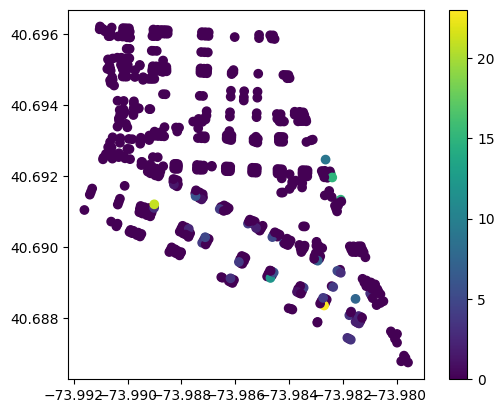

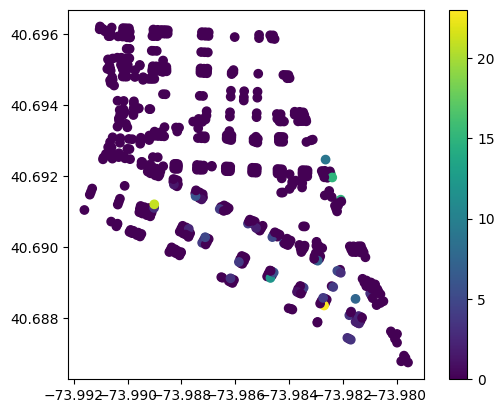

In [19]:
# Static visualisation
fig_static = (
    mapper
    .visual # From the visualiser module
    .with_type("Static")  # With type Static
    .show(columns=["avg_floors"])  # Show the avg_floors column
    .render(enriched_layer.get_layer()) # Render the enriched layer
)
fig_static

## Interactive Visualisation

Now, let’s go fancy with an interactive Folium map—dark theme, because why not?

In [20]:
# Interactive visualisation
fig_interactive = (
    mapper
    .visual # From the visualiser module
    .with_type("Interactive")  # With type Interactive
    .with_style({"tiles": "CartoDB dark_matter", "colorbar_text_color": "white"}) # Dark theme style
    .show(columns=["avg_floors"])  # Show the avg_floors column
    .render(enriched_layer.get_layer()) # Render the enriched layer
)
fig_interactive

## Preparing the Raster Data and Layer 
Let's prepare raster data and create a layer.

In [10]:
######
#
# We will on purpose do inline chaining of the methods to fasten the process.
#
######
%load_ext autoreload
%autoreload 2
# Load data
# Note: For the documentation interactive mode, we only query 5000 records from the dataset.  Feel free to remove for a more realistic analysis.
data = mapper.loader.from_file("../../src/urban_mapper/modules/loader/tests/data/lower_manhattan_dem.tif").with_options(bloc_size=10000000).load()

#Create urban layer

layer = mapper.urban_layer.with_type("streets_intersections").from_address("Lower Manhattan, New York City, New York, USA", dist = 100).build()

# Impute your data if they contain missing values
#data = mapper.imputer.with_type("SimpleGeoImputer").on_columns("longitude", "latitude").transform(data, layer)

# Filter your data if they contain data beyond the bounding box your urban layer above
#data = mapper.filter.with_type("BoundingBoxFilter").transform(data, layer)

# Map data to nearest layer
#_, mapped_data = layer.map_nearest_layer(
   # data,
    #longitude_column="longitude",
    #latitude_column="latitude",
    #output_column="nearest_intersection",
#)

# Enrich layer
#enricher = (
   # mapper.enricher
    #.with_data(group_by="nearest_intersection", values_from="numfloors")
    #.aggregate_by(method="mean", output_column="avg_floors")
    #.build()
#)

#enriched_layer = enricher.enrich(mapped_data, layer)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Raster Static Visualisation
Our data is ready, now let's visualised first with static visualisation.


In [ ]:
# Static visualisation
fig_static = (
    mapper
    .visual # From the visualiser module
    .with_type("Static")  # With type Static
    .show(columns=["value"])  # Show the avg_floors column
    .render(data) # Render the enriched layer
)


## Raster Interactive Visualisation
Now use the interactive one !


In [9]:
# Interactive visualisation
fig_interactive = (
    mapper
    .visual # From the visualiser module
    .with_type("Interactive")  # With type Interactive
    .with_style({"tiles": "CartoDB dark_matter", "colorbar_text_color": "white"}) # Dark theme style
    .show(columns=["value"])  # Show the avg_floors column
    .render(data) # Render the enriched layer
)
fig_interactive



MemoryError: 

## Be Able To Preview Your Visualiser

Want to check your visualiser’s setup? `preview()` shows you the type and style—perfect for shared projects!

In [ ]:
# Preview visualiser
print(mapper.visual.preview())

## Provide many different datasets to the same static visualization

You can load many datasets and feed the enricher with a dictionary. All the provided datasets should have the same columns provided in `with_data`, `aggregate_by`, etc.

The static visualizer looks into the enriched data with `data_id` column and uses it to show data with different markers.

In [ ]:
# Load CSV data
data1 = (
    mapper
    .loader
    .from_huggingface("oscur/pluto", number_of_rows=1000, streaming=True).with_columns("longitude", "latitude").load()
    # From the loader module, from the following file and with the `longitude` and `latitude`
)

# Load Parquet data
data2 = (
    mapper
    .loader
    .from_huggingface("oscur/taxisvis1M", number_of_rows=1000, streaming=True) # To update with your own path
    .with_columns("pickup_longitude", "pickup_latitude") # Inform your long and lat columns
    .with_map({"pickup_longitude": "longitude", "pickup_latitude": "latitude"}) ## Routines like layer.map_nearest_layer needs datasets with the same longitude_column and latitude_column    
    .load()
)

data = {
  "pluto_data": data1,
  "taxi_data": data2,
}

# Create a new urban layer to the data
layer = mapper.urban_layer.with_type("streets_intersections").from_place("Downtown Brooklyn, New York City, USA").build()

# Map datasets to the nearest layer
# Here the point is to say which intersection of the city maps with which record(s) in each of your datasets
# so that we can take into account when enriching.
_, mapped_data = layer.map_nearest_layer(
    data,
    longitude_column="longitude",
    latitude_column="latitude",
    output_column="nearest_intersection", # Will create this column in the data, so that we can re-use that throughout the enriching process below.
)

# Set up and apply enricher with debug enabled
enricher = (
    mapper
    .enricher # From the enricher module
    .with_data(
        group_by="nearest_intersection", values_from="numfloors", data_id="pluto_data"
    ) # Reading: With data grouped by the nearest intersection, and the values from the attribute numfloors
      #Both datasets should have the same group_by and values_from columns
    .aggregate_by(
        method="mean", output_column="avg_floors"
    ) # Reading: Aggregate by using the mean and output the computation into the avg_floors new attribute of the urban layer
    .with_debug()  # Enable debug to add DEBUG_avg_floors column which will contain the list of indices from the input data used for each enrichment
    .build()
)
enriched_layer = enricher.enrich(
    mapped_data, layer
)  # Data to use, Urban Layer to Enrich.

# Static visualisation
fig_static = (
    mapper
    .visual # From the visualiser module
    .with_type("Static")  # With type Static
    .show(columns=["avg_floors"])  # Show the avg_floors column
    .render(enriched_layer.get_layer()) # Render the enriched layer
)

# More visualiser primitives ?

Wants more? Come shout that out on https://github.com/VIDA-NYU/UrbanMapper/issues/9

## Wrapping Up

Blimey, you’re ace! 🌟 You’ve made static and interactive maps like a pro. Tweak the styles or columns next—you’re unstoppable! 🚀